<div>
<a href="https://colab.research.google.com/github/JontySinai/ProbabilisticProgramming/blob/master/my_BayesianMethodsForHackers/1_TextMessages.ipynb">
  <img style="float: left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

# Bayesian Methods for Hackers
## Text Messages 
**Chapter 01 - Introduction**<br>

**Source:** https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter1_Introduction



In [31]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip3 install -q wget
    import wget

In [29]:
import os
import typing

from typing import Dict, List, Tuple

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import scipy.stats as stats

import pymc3 as pm
import theano.tensor as tt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(1901)

### Test Messages Data

In [32]:
if IN_COLAB:
    print('Fetching data from Github ...')
    url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv'
    _data = wget.download(url, )
    filepath = "txtdata.csv"
else:
    filepath = os.path.join("data", "txtdata.csv")

txt_data = np.loadtxt(filepath)
n_txt_data = len(txt_data)

print(f'Number of days in observation period: {n_txt_data}')

Number of days in observation period: 74


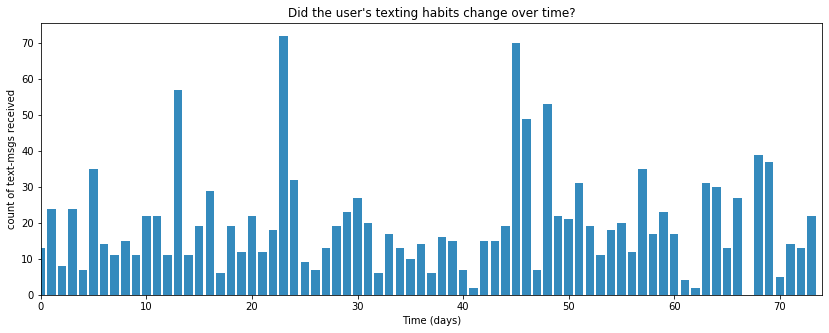

In [3]:
figsize(14, 5)

plt.bar(np.arange(n_txt_data), txt_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_txt_data);

# Mathematical Model

Let $c_t$ be the count of text messages received on day $t$. Then shall assume that

$$ c_t \sim \text{Poisson}(\lambda). $$

$\lambda$ is an _unknown **latent** parameter_. It is also a _random variable_ - which we shall place a prior on. Now looking at the data it appears that the average rate of messages received is higher later in the period than it is earlier in the period:

In [4]:
print(f'Rate in first half: {txt_data[:n_txt_data//2].mean():.3f}')
print(f'Rate in second half: {txt_data[n_txt_data//2:].mean():.3f}')

Rate in first half: 19.027
Rate in second half: 20.459


One way of representing this mathematically is to say that there is some day, $\tau$, at which the rate explicitly changes and so we actually have two latent variables (parent variables) of $\lambda$.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}.
$$

>If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We will use **Bayesian inference** to infer the unknown parameter $\lambda$, this requires us having a prior distribution. In the $Poission$ model, $\lambda$ must be positive, real. A reasonable candidate will be the $Exponential$ distribution which has parameter $\alpha$. Explicitly

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

Now for any 

$$ Z \sim Exp(\alpha), $$

the expected value of $Z$ is given by 

$$\mathbb{E}[\; Z \;|\; \alpha \;] = \frac{1}{\alpha}.$$


But for any

$$ X \sim Poisson(\lambda), $$

we have

$$\mathbb{E}[ \;X\; | \; \lambda \;] = \lambda. $$

So we have that 

$$ \frac{1}{N}\sum_{t=0}^Nc_t \approx \mathbb{E}[\; c\;|\; \lambda, \; \alpha] \approx \mathbb{E}[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$

$$\Rightarrow \alpha = \frac{1}{\frac{1}{N}\sum_{t=0}^Nc_t}.$$

What about $\tau$? We don't know precisely when this day occurred, so it is also a random variable. It is an integer, so we can choose

$$\tau \sim \text{DiscreteUniform(1, 74) }$$

$$\Rightarrow P( \tau = k ) = \frac{1}{74}$$

for integer $k$; $1 \leq k \leq 74$.

We then have the following parameters in our model

$$\theta = (\tau, \alpha, \lambda_1, \lambda_2).$$

### The factored graph and PPL's

This mathematical description of priors describes a _Bayesian network_ - a _directed graph_ from each parent variable to its child variables. Using a _probabilistic programming language_  it is not necessary to determine the mathematical formula for the full prior distribution. Furthermore, the posterior distribution may not even be analytically tractable. 

We will look at a number of different probabilistic programming languages in Python.

# PyMC3 Model

We can write $\theta$ as a simple `pymc3` model as follows:

In [5]:
with pm.Model() as model:
    alpha = 1.0/txt_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_txt_data - 1)

Some of these variables are random variables, and one ($\alpha$), is determined from the data:

In [6]:
print(f'Alpha: {type(alpha)}')
print(f'Lambda 1: {type(lambda_1)}')
print(f'Lambda 2: {type(lambda_2)}')
print(f'Tau: {type(tau)}')

Alpha: <class 'numpy.float64'>
Lambda 1: <class 'pymc3.model.TransformedRV'>
Lambda 2: <class 'pymc3.model.TransformedRV'>
Tau: <class 'pymc3.model.FreeRV'>


We can then use these to specify 

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}.
$$

In [7]:
with model:
    days = np.arange(n_txt_data) # Index
    lambda_ = pm.math.switch(tau > days, lambda_1, lambda_2)

Note that lambda itself is also a random variable

In [8]:
print(f'Lambda: {type(lambda_)}')

Lambda: <class 'theano.tensor.var.TensorVariable'>


Finally, we are interested in estimating the count data, $c_t$. We already have observed data, which we will condition on:

In [9]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=txt_data)

In [10]:
print(f'Observation: {type(observation)}')

Observation: <class 'pymc3.model.ObservedRV'>


### Optimization of posterior on parameters $\theta$ 

Let's take a moment to review what we have done so far. We have a random variable which we would like to model, $c$, which is $Poisson$ distributed with parameter $\lambda$, which is fully determined by $\theta = (\tau, \alpha, \lambda_1, \lambda_2)$. In other words we have the likelihood:

$$P(\; C \;| \; \theta \;),$$

and the prior

$$P(\; \theta \;).$$

We will then use the PPL to determine the posterior

$$P(\; \theta \;| \; C \;).$$

In other words:

>What is the probability on each of these parameters (btw this posterior can be factored for $\tau, \; \lambda_1, \; \lambda_2$), given the data which we have observed.

Now this distribution is intractable to us, so we will approximate it. The three most widely used classes of approximate inference algorithms are:

1. Monte Carlo sampling
2. Variational Inference
3. Expectation Propagation

As the name suggestes, `pymc3` is a Monte Carlo (sampling based) PPL. We will use the standard _Metropolis-Hastings_ sampler to estimate the posterior. 

In [11]:
# since we have specified the model, the optimisation part is fairly easy to write down
with model:
    step = pm.Metropolis()  # sample
    trace = pm.sample(10000, tune=5000, step=step)  # trace (stack) of samples

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:10<00:00, 2959.10draws/s]
The number of effective samples is smaller than 25% for some parameters.


Since we have used sampling-based approximate inference we don't have an analytical model to draw samples from the posterior, but we do have a _trace_ of the samples we made using Metropolis-Hastings (MH). 

>Note Metropolis-Hastings is _Markov Chain Monte Carlo (MCMC)_ sampling algorithm, which theoretically converges to the desired distribution. The initial samples will not be from the desired distribution and we should discard them. This process is known as "burn-in". In the `pymc3` API, the burn-in steps are specified by the `tune` argument above and are not included in the trace output.

In [12]:
print(f'Trace: {trace}')

Trace: <MultiTrace: 2 chains, 10000 iterations, 5 variables>


In [13]:
print(f'Posterior variables: {trace.varnames}')

Posterior variables: ['lambda_1_log__', 'lambda_2_log__', 'tau', 'lambda_1', 'lambda_2']


Let's visualise the trace samples drawn for each parameter:

In [14]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

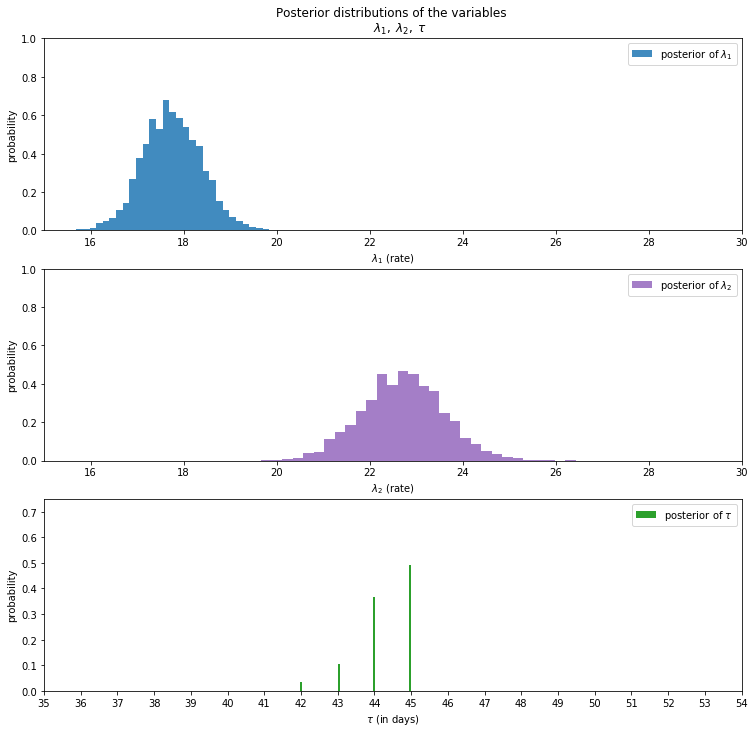

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(12.5, 12))

axs[0].set_autoscaley_on(False)
axs[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="tab:blue", density=True)
axs[0].legend(loc="upper right")
axs[0].set_title(r"""Posterior distributions of the variables 
    $\lambda_1,\;\lambda_2,\;\tau$""")
axs[0].set_xlim([15, 30])
axs[0].set_xlabel("$\lambda_1$ (rate)")
axs[0].set_ylabel("probability")

axs[1].set_autoscaley_on(False)
axs[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="tab:purple", density=True)
axs[1].legend(loc="upper right")
axs[1].set_xlim([15, 30])
axs[1].set_xlabel("$\lambda_2$ (rate)")
axs[1].set_ylabel("probability")

w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
axs[2].hist(tau_samples, bins=n_txt_data, alpha=1,
         label=r"posterior of $\tau$",
         color="tab:green", weights=w, rwidth=2.)
axs[2].set_xticks(np.arange(n_txt_data))
axs[2].legend(loc="upper right")
axs[2].set_ylim([0, .75])
axs[2].set_xlim([35, len(txt_data)-20])
axs[2].set_xlabel(r"$\tau$ (in days)")
axs[2].set_ylabel("probability")

plt.show()

### Expected Number of Texts Per Day

Now that we have a posterior distribution for $\theta$, we can use this to answer the original question:

>What is the expected number of texts per day?

Recall that for a $Poisson$ random variable, the expected value is given by the rate $\lambda$:

$$\mathbb{E}[\; X \;| \lambda \;] = \lambda \\\\ X \sim Poisson(\lambda).$$

In other words we just need to calculate the expected value of $\lambda$, and we assumed that

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}.
$$

So we need to know the expected values of $\tau, \ \lambda_1, \lambda_2$, which we can compute using the MCMC sample trace which our PPL has generated for us.

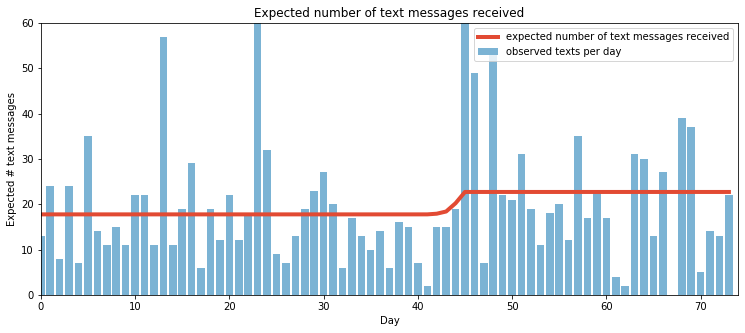

In [16]:
N = tau_samples.shape[0]  # this is the same for lambda_1 and lambda_2
expected_texts_per_day = np.zeros(n_txt_data)
for day in range(0, n_txt_data):
    
    # First we need to determine for which samples of tau, should we use
    # lambda_1 or lambda_2 on this day
    case_1_idx = day < tau_samples
    # Second, to get an expected value of lambda for that day, we should 
    # still average of lambda_1 and lambda_2 for that
    expected_texts_per_day[day] = ( lambda_1_samples[case_1_idx].sum()
                                    + lambda_2_samples[~case_1_idx].sum() ) / N
    
figsize(12.5, 5)


plt.bar(np.arange(len(txt_data)), txt_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")
plt.plot(range(n_txt_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text messages received")

plt.legend(loc="upper right")
plt.xlabel("Day")
plt.ylabel("Expected # text messages")
plt.title("Expected number of text messages received")

plt.xlim(0, n_txt_data)
plt.ylim(0, 60)

plt.show()

# TensorFlow Probability Model

To distinguish the `tensorflow` part from the PyMC3 part we will use a different `matplolibstyle`, namely the `fivethirtyeight` style. The same style is used in the `tensorflow` port of the book.

In [17]:
matplotlib_style = 'fivethirtyeight'
plt.style.use(matplotlib_style)

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow_core._api.v2.config' from '/Users/jontysinai/anaconda3/envs/axiom/lib/python3.7/site-packages/tensorflow_core/_api/v2/config/__init__.py'>

In [18]:
txt_tensor = tf.constant(np.loadtxt("data/txtdata.csv").astype(np.float32), dtype=tf.float32)
days = tf.range(n_txt_data, dtype=tf.int32)

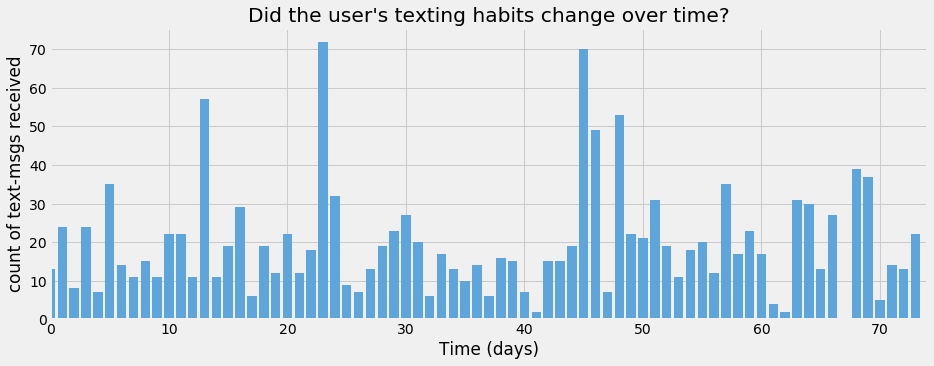

In [19]:
figsize(14, 5)

plt.bar(days.numpy(), txt_tensor, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_txt_data);

TFP performs probabilistic inference by evaluating the model parameters using a `joint_log_prob` function which we will base, almost $1:1$, on the following mathematical model:

$$\begin{align*}
\lambda_{1} &\sim Exp(\alpha) &\\
\lambda_{2} &\sim Exp(\alpha) &\\
\tau &\sim Uniform[0,1) &\\
\\
\text{for }  i &= 1\ldots N: &\\
&\lambda_i = 
\begin{cases} 
&\lambda_{1}, & \tau > i/N \\ 
&\lambda_{2}, & \text{otherwise}
\end{cases}\\
\\
 X_i &\sim \text{Poisson}(\lambda_i)&
\end{align*}$$

In [20]:
# tfp model
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(
                    tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= \
                    tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), 
                 dtype=tf.int32))
    
    rv_observation = tfd.Poisson(rate=lambda_)
     
    # since we are using a joint_log_prob model, we return the factored sum
    # NOTE: `+` here is an operation between `tensorflow_probability.distribution` objects. 
    # This is the mathematically concise way of writing this as a factored posterior.
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(txt_tensor, lambda1, lambda2, tau)

Now let's specify the posterior sampler in `tensorflow-probability`:

In [21]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)

In [22]:
# sampling parameters
num_burnin_steps = 5000
num_results = 20000
step_size = 0.2

# sampling start state: E[theta]
initial_chain_state = [
    tf.cast(tf.reduce_mean(txt_tensor), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(txt_tensor), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]

We will be using the _Hamiltonian Monte Carlo (HMC)_ sampler, which operates over $\mathbb{R}^{d}$, which is an unconstrained space. `tensorflow-probability` has a set of _bijectors_ (`tfb`) which we can use to biject the constrained space of each parameter with $\mathbb{R}^{d}$.

In [23]:
real_bijectors = [
    tfb.Exp(),       # Maps a positive real to R.
    tfb.Exp(),       # Maps a positive real to R.
    tfb.Sigmoid(),   # Maps [0,1] to R.  
]

In `tensorflow-probability`, the sampler is specified as a _Markov Transition Kernel_ :

In [24]:
inner_kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=real_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=inner_kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

Now let's get posterior samples of the `unnormalized_log_posterior` using the HMC Markov kernel

In [25]:
trace, kernel_results = graph_sample_chain(
                            num_results=num_results,
                            num_burnin_steps=num_burnin_steps,
                            current_state=initial_chain_state,
                            kernel = kernel)

lambda_1_samples = trace[0]
lambda_2_samples = trace[1]
posterior_tau    = trace[2]
    
tau_samples = tf.floor(posterior_tau * tf.cast(n_txt_data, dtype=tf.float32))

/Users/jontysinai/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Since `tensorflow-probability` implements HMC using the _No U-Turn Sampler (NUTS)_ by default, the step-size is adaptive and we can inspect its final value (initial value was 0.2)

In [26]:
print("Acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted, dtype=tf.float32))))
print("Final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))



Acceptance rate: 0.5995500087738037
Final step size: 0.028447363525629044


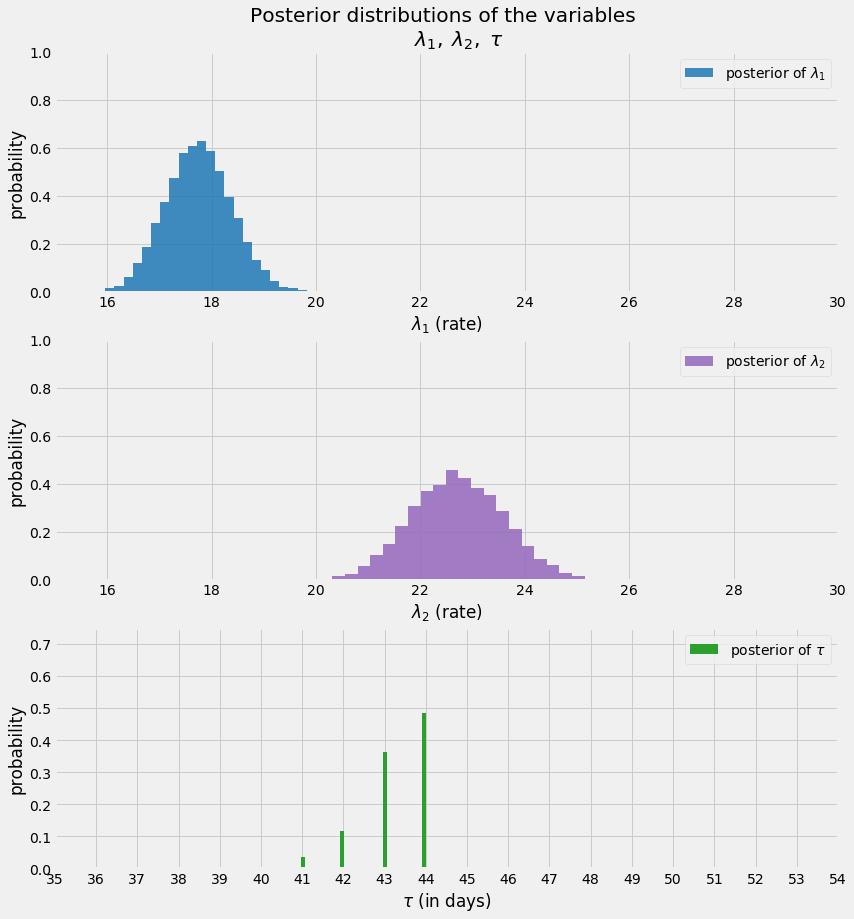

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(12.5, 14))

axs[0].set_autoscaley_on(False)
axs[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="tab:blue", density=True)
axs[0].legend(loc="upper right")
axs[0].set_title(r"""Posterior distributions of the variables 
    $\lambda_1,\;\lambda_2,\;\tau$""")
axs[0].set_xlim([15, 30])
axs[0].set_xlabel("$\lambda_1$ (rate)")
axs[0].set_ylabel("probability")

axs[1].set_autoscaley_on(False)
axs[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="tab:purple", density=True)
axs[1].legend(loc="upper right")
axs[1].set_xlim([15, 30])
axs[1].set_xlabel("$\lambda_2$ (rate)")
axs[1].set_ylabel("probability")

w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
axs[2].hist(tau_samples, bins=n_txt_data, alpha=1,
         label=r"posterior of $\tau$",
         color="tab:green", weights=w, rwidth=2.)
axs[2].set_xticks(np.arange(n_txt_data))
axs[2].legend(loc="upper right")
axs[2].set_ylim([0, .75])
axs[2].set_xlim([35, len(txt_data)-20])
axs[2].set_xlabel(r"$\tau$ (in days)")
axs[2].set_ylabel("probability")

plt.show()

Finally let's plot the expected number of text messages received

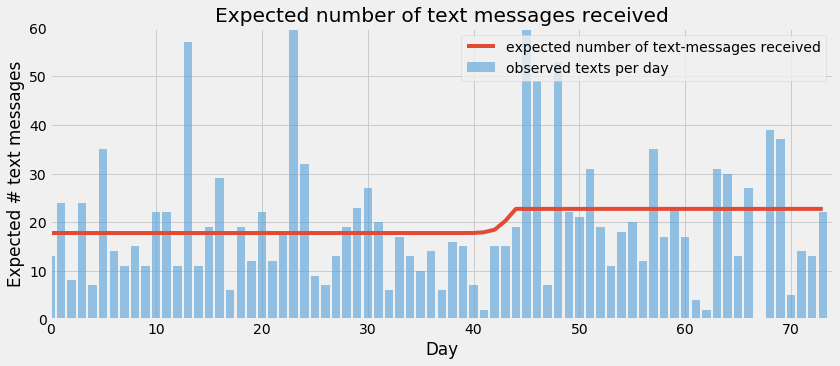

In [28]:
N = tau_samples.shape[0]
expected_texts_per_day = tf.zeros((N, n_txt_data), dtype=tf.float32)  # init: (10000,74)

day_range = tf.range(0, n_txt_data, delta=1, dtype = tf.int32)
# expand from shape of 74 to (10000,74)
day_range = tf.expand_dims(day_range, 0)
day_range = tf.tile(day_range, tf.constant([N, 1]))

# expand from shape of 10000 to (10000,74)
tau_samples_per_day = tf.expand_dims(tau_samples, 0)
tau_samples_per_day = tf.transpose(tf.tile(tau_samples_per_day, tf.constant([day_range.shape[1],1])))
tau_samples_per_day = tf.cast(tau_samples_per_day, dtype=tf.int32)

# (10000,74) tensor where axis=0 is number of samples, axis=1 is day. 
# Each value is true iff (sample,day) value is < tau_sample value
case_1_idx = day_range < tau_samples_per_day

# lambda_1 mean per day: expand from shape of 10000 to (10000,74)
lambda_1_samples_per_day = tf.expand_dims(lambda_1_samples, 0)
lambda_1_samples_per_day = tf.transpose(tf.tile(lambda_1_samples_per_day, tf.constant([day_range.shape[1],1])))
# lambda_2 mean per day: expand from shape of 10000 to (10000,74)
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples, 0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day, tf.constant([day_range.shape[1],1])))

expected_texts_per_day = ((
    tf.reduce_sum(lambda_1_samples_per_day*tf.cast(case_1_idx, dtype=tf.float32),axis=0) + \
    tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~case_1_idx, dtype=tf.float32), axis=0) 
) / N )

figsize(12.5, 5)

plt.bar(np.arange(len(txt_tensor)), txt_tensor, color="#5DA5DA", alpha=0.65,
        label="observed texts per day")
plt.plot(range(n_txt_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")

plt.legend(loc="upper right")
plt.xlabel("Day")
plt.ylabel("Expected # text messages")
plt.title("Expected number of text messages received")

plt.xlim(0, n_txt_data)
plt.ylim(0, 60);